# A TUTORIAL ON VARIANCE-BASED SENSITIVITY ANALYSIS FOR INDEPENDENT INPUTS

by Sebastian T. Glavind, October, 2020

# Introduction

In this tutorial, we will consider different approaches to perform variance-based sensitivity analysis (SA) when the input variables are independent. First, we will study how linear regression may be used for SA; and second, we will consider some simulation-based approaches for SA introduced in Saltelli et al.(2008; 2010) and Kucherenko et al.(2012).
***
Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D., Saisana, M., & Tarantola, S. (2008). Global sensitivity analysis: the primer. John Wiley & Sons.

Saltelli, A., Annoni, P., Azzini, I., Campolongo, F., Ratto, M., & Tarantola, S. (2010). Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index. Computer physics communications, 181(2), 259-270.

Kucherenko, S., Tarantola, S., & Annoni, P. (2012). Estimation of global sensitivity indices for models with dependent variables. Computer physics communications, 183(4), 937-946.
***

# Prelude

In [1]:
import numpy as np
import sklearn.model_selection
import sklearn.preprocessing
import scipy.stats as ss
import smt.sampling_methods
import pandas as pd
import openturns as ot
import pickle
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

# Variance decomposition based on regression

In this section, we will consider linear regression for SA based on a simple linear and non-linear example. The interested reader is referred to Saltelli et al.(2008) for the technical details.

***
Saltelli, A., Ratto, M., Andres, T., Campolongo, F., Cariboni, J., Gatelli, D., Saisana, M., & Tarantola, S. (2008). Global sensitivity analysis: the primer. John Wiley & Sons.
***

## Implementation

In [2]:
def mySRA(X,y):
    # Design matrix
    XX = np.hstack([np.ones([X.shape[0],1]),X])
    # Linear regression
    coef = np.dot( np.linalg.pinv(XX), y )
    
    # Standardized regression coefficients acc. variance contribution
    SRC = coef * np.std(XX,0) / np.std(y)
    # Squared SRC
    SRCsq = SRC**2
    
    # R2 score
    yest = np.dot( XX , coef )
    Rsq = 1 - np.sum( (y-yest)**2 ) / np.sum( (y-np.mean(y))**2 )  
        
    return(coef, SRCsq, Rsq)

## Example 1: Linear model

To showcase the approach, we will initially consider the following simple problem: 

$$ y = x_1 + x_2 + x_3$$

where the variables are uniformly distributed as $x_1 \sim \mathcal{U}(0.5,1.5)$, $x_2 \sim \mathcal{U}(1.5,4.5)$ and $x_3 \sim \mathcal{U}(4.5,13.5)$.

### Analytical solution

See Saltelli et al.(2008), Sec. 4.10, Exercise 1 for the details;

$$ S_1 = \frac{1}{91} = 0.011; \ S_2 = \frac{9}{91} = 0.099; \ \text{and} \ S_3 = \frac{1}{81} = 0.890. $$

Note that there are no interaction terms, so $S_i^T = S_i$.

### Copula implementations

This is used to transform the variables with a identity matrix, as no correlation is considered.

In [3]:
# This implementation corresponds to a standard Gaussian copula, see e.g.
# https://se.mathworks.com/help/stats/copulas-generate-correlated-samples.html
# https://www.sciencedirect.com/science/article/abs/pii/0266892086900330?via%3Dihub
def gaussian_copula_c1a(CorrMat, lower, upper, Nsamp):
    m = CorrMat.shape[1]
    MVN = ss.multivariate_normal( mean = np.zeros(m), cov = CorrMat )
    Z = MVN.rvs(size=Nsamp) 
    U = ss.norm.cdf(Z)
    X = np.zeros(U.shape)
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower[i], scale=upper[i]-lower[i]).ppf(U[:,i]) # define transformation
    y = X[:,0] + X[:,1] + X[:,2]
    return(X,y)

# This implementation corresponds to a Gaussian copula with a latin hypercube design
def gaussian_copula_c1a_lhs(CorrMat, lower, upper, Nsamp):
    m = CorrMat.shape[1] # no. of variables
    L = np.linalg.cholesky(CorrMat) # cholesky decomposition of covariance (correlation) matrix
    lhs_sampler = smt.sampling_methods.LHS(xlimits=np.tile(np.array([0,1]), (m, 1))) # latin hypercube sampling
    Ulhs = lhs_sampler(Nsamp) # do.
    Zuncor = ss.norm.ppf(Ulhs) # uncorrelated standard normal samples
    Zcor = np.dot(L, Zuncor.T).T # correlated standard normal samples
    U = ss.norm.cdf(Zcor) # correlated uniformly distributed samples
    X = np.zeros(U.shape) 
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower[i], scale=upper[i]-lower[i]).ppf(U[:,i]) # define transformation
    y = X[:,0] + X[:,1] + X[:,2]
    return(X,y)

### Sampling

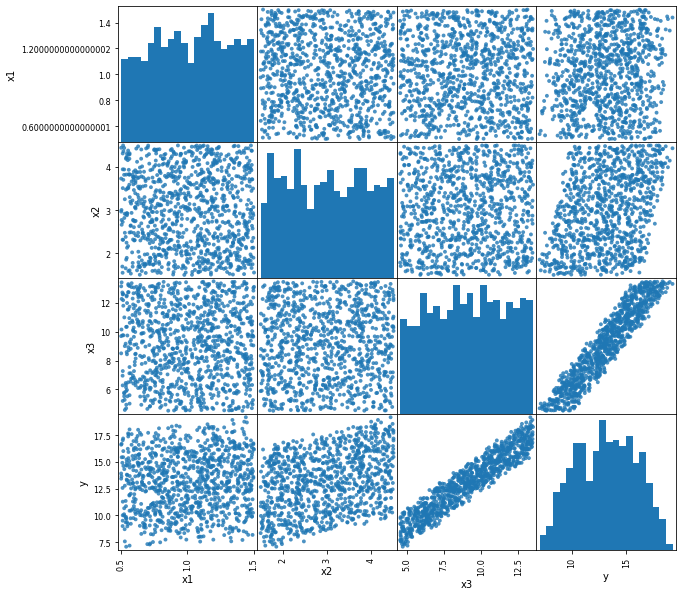

In [4]:
# Standard Gaussian copula
CorrMat_c1a = np.array([ [1., 0, 0], [0, 1., 0], [0, 0, 1.] ])
lower_c1a = np.array([0.5, 1.5, 4.5])
upper_c1a = np.array([1.5, 4.5, 13.5])
np.random.seed(42)
Xc1a, yc1a = gaussian_copula_c1a(CorrMat_c1a, lower_c1a, upper_c1a, 1000) # regular sampling
# plotting
dfXyc1a = pd.DataFrame(np.hstack((Xc1a, yc1a.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc1a, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

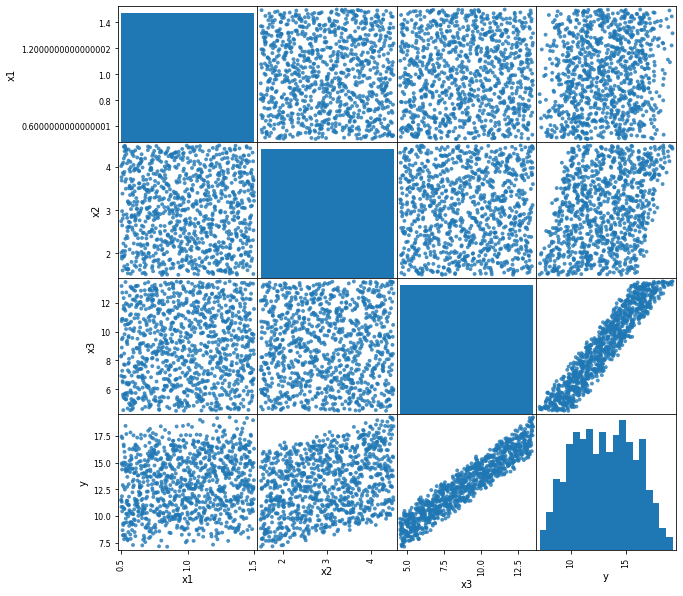

In [5]:
# Standard Gaussian copula
np.random.seed(42)
Xc1a_lhs, yc1a_lhs = gaussian_copula_c1a_lhs(CorrMat_c1a, lower_c1a, upper_c1a, 1000) # regular sampling
# plotting
dfXyc1a_lhs = pd.DataFrame(np.hstack((Xc1a_lhs, yc1a_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc1a_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute regression-based indices

In [6]:
coef_c1a, SRCeq_c1a, Rsq_c1a = mySRA(Xc1a_lhs,yc1a_lhs)
print( 'Squared, standardized regression coefficients: ', SRCeq_c1a[range(1,4)], ', sum: ', np.sum(SRCeq_c1a[range(1,4)]) ) # almost the same as analytical values
print( 'R-squared for the linear regression model: ', Rsq_c1a )

Squared, standardized regression coefficients:  [0.0109066  0.09815939 0.88343455] , sum:  0.9925005433088644
R-squared for the linear regression model:  1.0


$R^2$ = 1.0 means that 100% of the variance in the original model outputs are captured by the linear regression model (models for which $R^2$ > 0.7 are usually considered sufficiently linear for the SRCs to be considered for SA).


## Example 2: Non-linear model (Ishigami function)

We will now consider the following non-linear model: 

$$ y = \sin(x_1) + a \sin^2(x_2) + b x_3^4 \sin(x_1) $$

where $a=7$, $b=0.1$, and the variables are assumed to follow a uniform distribution, i.e. $x_i \sim \mathcal{U}(-\pi,\pi), i \in \{1,2,3\}$.

### Analytical solution

See Saltelli et al.(2008), Sec. 4.10, Exercise 5 for the details;

$$ V_1 = \frac{1}{2} + \frac{b \pi^4}{5} + \frac{b^2 \pi^8}{50}; \ V_2 = \frac{a^2}{8}; \ V_3 = 0 $$

$$ V_y = \frac{1}{2} + \frac{a^2}{8} + \frac{b \pi^4}{5} + \frac{b^2 \pi^8}{18} $$

and thus

$$ S_1 = 0.314; \ S_2 = 0.442; \ S_3 = 0. $$

See also Kucherenko et al.(2016) and https://uqworld.org/t/ishigami-function/55, where both $S_i$'s and $S_i^T$ appear for this case, thus

$$ S_1^T = 0.557; \ S_2^T = 0.442; \ S_3^T = 0.244. $$

***
Kucherenko, S., Delpuech, B., Iooss, B., & Tarantola, S. (2015). Application of the control variate technique to estimation of total sensitivity indices. Reliability Engineering & System Safety, 134, 251-259.
***

### Copula implementations

This is used to transform the variables with a identity matrix, as no correlation is considered.

In [7]:
# This implementation corresponds to a Gaussian copula with a latin hypercube design
def gaussian_copula_c1b_lhs(CorrMat, lower, upper, Nsamp):
    m = CorrMat.shape[1] # no. of variables
    L = np.linalg.cholesky(CorrMat) # cholesky decomposition of covariance (correlation) matrix
    lhs_sampler = smt.sampling_methods.LHS(xlimits=np.tile(np.array([0,1]), (m, 1))) # latin hypercube sampling
    Ulhs = lhs_sampler(Nsamp) # do.
    Zuncor = ss.norm.ppf(Ulhs) # uncorrelated standard normal samples
    Zcor = np.dot(L, Zuncor.T).T # correlated standard normal samples
    U = ss.norm.cdf(Zcor) # correlated uniformly distributed samples
    X = np.zeros(U.shape) 
    for i in range(m):
        X[:,i] = ss.uniform(loc=lower[i], scale=upper[i]-lower[i]).ppf(U[:,i]) # define transformation
    y = np.sin(X[:,0]) + 7 * np.sin(X[:,1])**2 + 0.1 * X[:,2]**4 * np.sin(X[:,0])
    return(X,y)

### Sampling

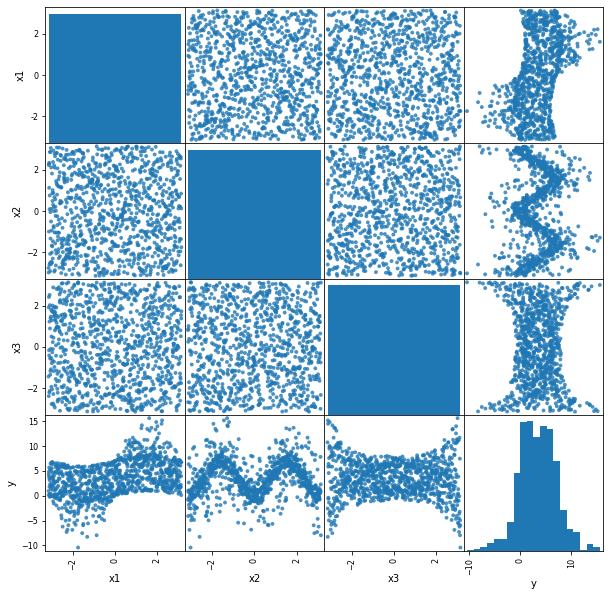

In [8]:
# Standard Gaussian copula
CorrMat_c1b = np.array([ [1., 0, 0], [0, 1., 0], [0, 0, 1.] ])
lower_c1b = np.repeat(-np.pi, 3)
upper_c1b = np.repeat(np.pi, 3)
np.random.seed(42)
Xc1b_lhs, yc1b_lhs = gaussian_copula_c1b_lhs(CorrMat_c1b, lower_c1b, upper_c1b, 1000) # regular sampling
# plotting
dfXyc1b_lhs = pd.DataFrame(np.hstack((Xc1b_lhs, yc1b_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc1b_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute regression-based indices

In [9]:
coef_c1b, SRCeq_c1b, Rsq_c1b = mySRA(Xc1b_lhs,yc1b_lhs)
print( 'Squared, standardized regression coefficients: ', SRCeq_c1b[range(1,4)], ', sum: ', np.sum(SRCeq_c1b[range(1,4)]) ) # almost the same as analytical values
print( 'R-squared for the linear regression model: ', Rsq_c1b )

Squared, standardized regression coefficients:  [0.17556733 0.00032096 0.0019429 ] , sum:  0.17783119504749365
R-squared for the linear regression model:  0.17808222710187116


$R^2$ = 0.21 means that only 21% of the variance in the original model outputs are captured by the linear regression model (models for which $R^2$ > 0.7 are usually considered sufficiently linear for the SRCs to be be considered for SA).


# Random sampling with binning

In this section, we consider a simple divide and conquer scheme, where the conditional variances are calculated as

$$ \mathbb{V}_i = \frac{1}{B} \sum_{b=1}^B \left( \frac{1}{N_b} \sum_{n_b=1}^{N_b} f(\mathbf{x}[n_b]|x_i \in b) \right)^2 - f_0^2, $$

where $B$ is the number of bins, and $N_b$ is the number of observations of $X_i$ that fall in bin $b \in \{1,2,...,B\}$. See e.g. Kucherenko et al.(2012) for further details.

***
Kucherenko, S., Tarantola, S., & Annoni, P. (2012). Estimation of global sensitivity indices for models with dependent variables. Computer physics communications, 183(4), 937-946.
***

## Implementation

In [10]:
def randomSamplingWithBinning(X, y, Nbins):
    # initialization
    nX, mX = X.shape
    subset = nX / Nbins; 
    # allocate objects
    VV = np.zeros([mX])
    SS = np.zeros([mX])

    # model output variance; object allocation
    varY = np.var(y) 
    f0Y = np.mean(y)
    # loop over variables
    for i in range(mX):
        # sort arrays according to Xi
        ix = np.argsort(X[:,i])
        yi = y[ix]; # Xi = X[ix,i];
        # allocate object for mean output in bin k of Xi
        meanYik = np.zeros([Nbins])
        # loop over bins
        for k in range(Nbins):
            kind = np.arange(k*subset, (k+1)*subset, 1).astype(int);
            yik = yi[kind]; # Xik = Xi[kind]; 
            meanYik[k] = np.mean(yik);

        VV[i] = np.mean(meanYik**2) - f0Y**2
        SS[i] = VV[i] / varY
            
    return(varY, VV, SS)

## Example 1: Linear model

See model description above.

### Sampling

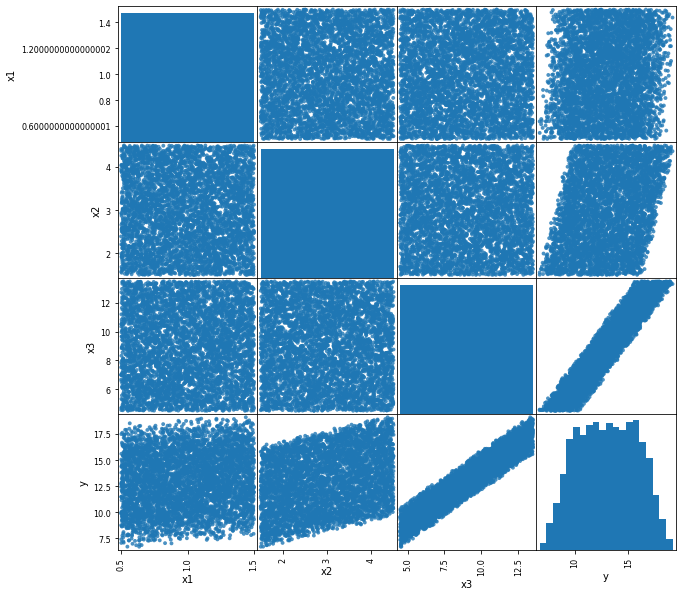

In [11]:
# Standard Gaussian copula
np.random.seed(42)
Xc2a_lhs, yc2a_lhs = gaussian_copula_c1a_lhs(CorrMat_c1a, lower_c1a, upper_c1a, 5000) # regular sampling
# plotting
dfXyc2a_lhs = pd.DataFrame(np.hstack((Xc2a_lhs, yc2a_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc2a_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute SA indices

In [12]:
Nbins_c2a = 50; # define number of slices

varYc2a, VVc2a, SSc2a = randomSamplingWithBinning(Xc2a_lhs, yc2a_lhs, Nbins_c2a)
print( 'First-order SA indices', SSc2a, ', sum: ', np.sum(SSc2a) ) # almost the same as analytical values

First-order SA indices [0.02391254 0.10121962 0.89106133] , sum:  1.0161934906997592


## Example 2: Non-linear model (Ishigami function)

See model description above.

### Sampling

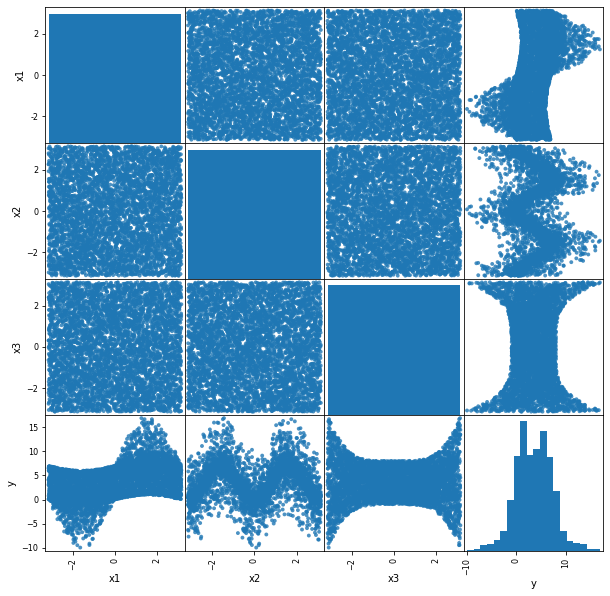

In [13]:
np.random.seed(42)
Xc2b_lhs, yc2b_lhs = gaussian_copula_c1b_lhs(CorrMat_c1b, lower_c1b, upper_c1b, 5000) # regular sampling
# plotting
dfXyc2b_lhs = pd.DataFrame(np.hstack((Xc2b_lhs, yc2b_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc2b_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute SA indices

In [14]:
Nbins_c2b = 50; # define number of slices

varYc2b, VVc2b, SSc2b = randomSamplingWithBinning(Xc2b_lhs, yc2b_lhs, Nbins_c2b)
print( 'First-order SA indices', SSc2b, ', sum: ', np.sum(SSc2b) ) # almost the same as analytical values

First-order SA indices [0.32847156 0.45066219 0.00485382] , sum:  0.7839875749721882


# Efficient Monte Carlo sampling

In this section, we will consider efficient Monte Carlo schemes for SA based on the examples considered in the foregoing. The interested reader is referred to Saltelli et al.(2010) for the technical details.

***
Saltelli, A., Annoni, P., Azzini, I., Campolongo, F., Ratto, M., & Tarantola, S. (2010). Variance based sensitivity analysis of model output. Design and estimator for the total sensitivity index. Computer physics communications, 181(2), 259-270.
***

## Implementation

In [15]:
def efficientMCforSA(X,y,fout):
    # define A and B matrices, along with associated outputs
    A, B, yA, yB = sklearn.model_selection.train_test_split(X, y, train_size=.5, shuffle=True, random_state=1)
    
    nA, mA = A.shape
    yBA = yAB = np.zeros([nA,mA])
    for i in range(mA):
        # Pertube inputs
        BA = B.copy()
        BA[:,i] = A[:,i]
        AB = A.copy()
        AB[:,i] = B[:,i]
        # Compute corresponding outputs
#         yBA[:,i] = fout(BA)
        yAB[:,i] = fout(AB)
    
    # Compute Si and STi
    f0 = np.mean(y) # use all data to estimate the mean (improve statistical power)
    vary = np.var(y) # use all data to estimate the variance
    vx1 = np.zeros([mA]); Si1 = np.zeros([mA]); ex1 = np.zeros([mA]); STi1 = np.zeros([mA])
    vx2 = np.zeros([mA]); Si2 = np.zeros([mA]); ex2 = np.zeros([mA]); STi2 = np.zeros([mA])
    vx3 = np.zeros([mA]); Si3 = np.zeros([mA]); STi3 = np.zeros([mA])
    for i in range(mA):
#         yBAi = yBA[:,i] 
        yABi = yAB[:,i]
        
        # Saltelli et al.(2010)
        vx2[i] = np.dot(yB, (yABi - yA))/nA
        Si2[i] = vx2[i] / vary ; # first-order sensitivity index
        ex2[i] = np.sum((yA - yABi)**2)/(2*nA)
        STi2[i] = ex2[i] / vary ; # total effects index
        
        # Jansen et al.(1999)
        vx3[i] = vary - np.sum((yB - yABi)**2)/(2*nA)
        Si3[i] = vx3[i] / vary ; # first-order sensitivity index
        STi3[i] = STi2[i] # # total effects index, i.e. same as Saltelli's method
    
    return(Si2, STi2, Si3, STi3)    

### Example 1: Linear model

See model description above.

### Sampling

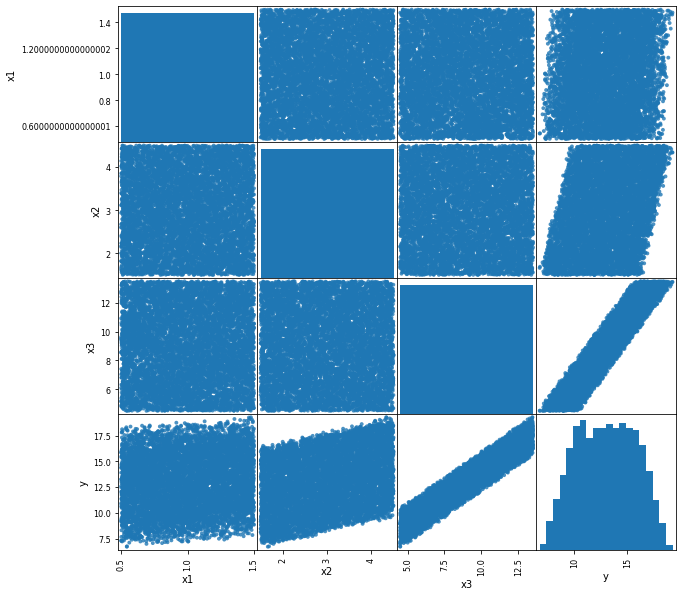

In [16]:
# Standard Gaussian copula
np.random.seed(42)
Xc3a_lhs, yc3a_lhs = gaussian_copula_c1a_lhs(CorrMat_c1a, lower_c1a, upper_c1a, 8000) # regular sampling
# plotting
dfXyc3a_lhs = pd.DataFrame(np.hstack((Xc3a_lhs, yc3a_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc3a_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

### Compute SA indices

In [17]:
# Output function (only) for evaluation of perturbed design matrices
def fout_c3a(X):
    y = X[:,0] + X[:,1] + X[:,2]
    return(y)

# Si and STi indices
Si2_c3a, STi2_c3a, Si3_c3a, STi3_c3a = efficientMCforSA(Xc3a_lhs, yc3a_lhs,fout_c3a)
print('Saltelli\'s methods: Si = ', Si2_c3a, ', STi = ', STi2_c3a)
print('Jansen\'s methods: Si = ', Si3_c3a, ', STi = ', STi3_c3a)  # almost the same as analytical values

Saltelli's methods: Si =  [0.03541059 0.15091627 0.77547721] , STi =  [0.01106289 0.09967412 0.8521626 ]
Jansen's methods: Si =  [0.04799522 0.14522638 0.88945775] , STi =  [0.01106289 0.09967412 0.8521626 ]


## Example 2: Non-linear model (Ishigami function)

See model description above.

### Sampling

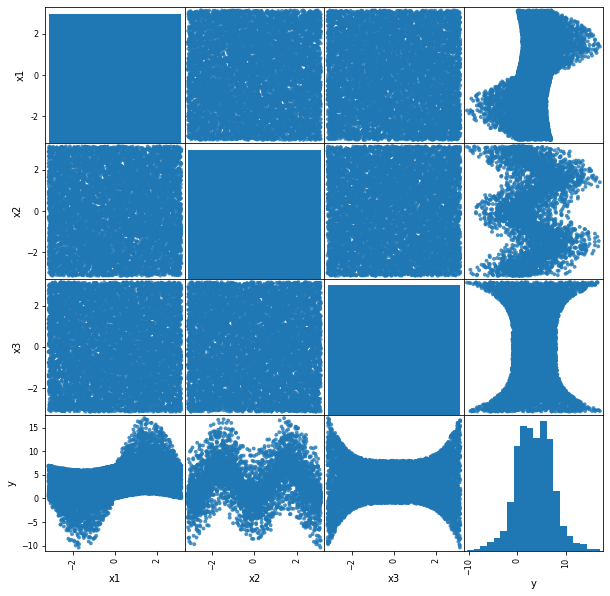

In [26]:
np.random.seed(42)
Xc3b_lhs, yc3b_lhs = gaussian_copula_c1b_lhs(CorrMat_c1b, lower_c1b, upper_c1b, 8000) # regular sampling
# plotting
dfXyc3b_lhs = pd.DataFrame(np.hstack((Xc3b_lhs, yc3b_lhs.reshape(-1,1))), columns=['x1', 'x2', 'x3', 'y'])
pd.plotting.scatter_matrix(dfXyc3b_lhs, figsize=(10, 10), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8);

In [27]:
# Output function (only) for evaluation of perturbed design matrices
def fout_c3b(X):
    y = np.sin(X[:,0]) + 7 * np.sin(X[:,1])**2 + 0.1 * X[:,2]**4 * np.sin(X[:,0])
    return(y)

# Si and STi indices
Si2_c3b, STi2_c3b, Si3_c3b, STi3_c3b = efficientMCforSA(Xc3b_lhs, yc3b_lhs,fout_c3b)
print('Saltelli\'s methods: Si = ', Si2_c3b, ', STi = ', STi2_c3b)
print('Jansen\'s methods: Si = ', Si3_c3b, ', STi = ', STi3_c3b)  # almost the same as analytical values

Saltelli's methods: Si =  [ 0.28283208  0.42188584 -0.01858202] , STi =  [0.52614349 0.4477371  0.22592083]
Jansen's methods: Si =  [0.32752431 0.45876415 0.02347893] , STi =  [0.52614349 0.4477371  0.22592083]
